# Random forest with Entity Embeddings: Training the model

We compare the validation set performance of a random forest on two version of the ASHRAE dataset (preprocessed [in Part 1](https://www.kaggle.com/michelezoccali/random-forest-with-embeddings-tutorial-part-1)), differing in the treatment of categorical variables. These are treated:

1. with **standard ordinal encoding** (discrete levels), and
2. with **Entity Embeddings**, i.e. vectors of continuous values previously learned by a neural net.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import os
import datetime
import warnings
import gc

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

from tqdm.notebook import tqdm

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = '../input/random-forest-with-embeddings-tutorial-part-1'

for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/random-forest-with-embeddings-tutorial-part-1/y_train.feather
../input/random-forest-with-embeddings-tutorial-part-1/__results__.html
../input/random-forest-with-embeddings-tutorial-part-1/X_embeds.feather
../input/random-forest-with-embeddings-tutorial-part-1/X_train.feather
../input/random-forest-with-embeddings-tutorial-part-1/__resultx__.html
../input/random-forest-with-embeddings-tutorial-part-1/__notebook__.ipynb
../input/random-forest-with-embeddings-tutorial-part-1/__output__.json
../input/random-forest-with-embeddings-tutorial-part-1/custom.css


# Load data

In [3]:
X_train = pd.read_feather(f'{data_path}/X_train.feather')
y_train = pd.read_feather(f'{data_path}/y_train.feather').meter_reading

In [4]:
y_train

0           3.190624
1           0.318163
2           0.000000
3           5.171529
4           4.524668
              ...   
19869881    2.277267
19869882    1.762159
19869883    0.000000
19869884    5.078761
19869885    1.348073
Name: meter_reading, Length: 19869886, dtype: float32

# Modeling

Let us write a small wrapper function for the Random Forest, to be passed to a CV routine.

In [5]:
def RF_wrapper(Xt, yt, Xv, yv, fold=-1):
    
    model = RandomForestRegressor(n_jobs=-1, n_estimators=40,
                              max_samples=200000, max_features=0.5,
                              min_samples_leaf=5, oob_score=False).fit(Xt, yt)
    print(f'Training fold {fold}...')
    
    score_train = np.sqrt(mean_squared_error(model.predict(Xt), yt))
    oof = model.predict(Xv)
    score = np.sqrt(mean_squared_error(oof, yv))
    print(f'Fold {fold}: training RMSLE: {score_train},   validation RMSLE: {score}\n')
    return model, oof, score

Let us perform k-fold CV, without shuffling as this is a time series. An alternative would be to do a single train/validation split, possibly with a gap to mimic training/private split. Otherwise, one could try something like Time-series split CV.

In [6]:
def perform_CV(model_wrap, xs, ys, n_splits=3):
    
    kf = KFold(n_splits=n_splits, shuffle=False)

    models = []
    scores = []
    oof_total = np.zeros(xs.shape[0])


    for fold, (train_idx, val_idx) in enumerate(kf.split(xs), start=1):
        Xt, yt = xs.iloc[train_idx], ys[train_idx]
        Xv, yv = xs.iloc[val_idx], ys[val_idx]
        model, oof, score = model_wrap(Xt, yt, Xv, yv, fold)

        models.append(model)
        scores.append(score)
        oof_total[val_idx] = oof

    print('Training completed.')
    print(f'> Mean RMSLE across folds: {np.mean(scores)}, std: {np.std(scores)}')
    print(f'> OOF RMSLE: {np.sqrt(mean_squared_error(ys, oof_total))}')
    return models, scores, oof_total

Let's train the random forest **without** embeddings.

In [7]:
%%time
n_splits = 3
models, _, _ = perform_CV(RF_wrapper, X_train, y_train, n_splits=n_splits)

Training fold 1...
Fold 1: training RMSLE: 0.8641581811323675,   validation RMSLE: 1.135297816894582

Training fold 2...
Fold 2: training RMSLE: 0.8861530306233435,   validation RMSLE: 1.062795692086431

Training fold 3...
Fold 3: training RMSLE: 0.8125067434335801,   validation RMSLE: 1.1550053149771922

Training completed.
> Mean RMSLE across folds: 1.1176996079860684, std: 0.03964783605700621
> OOF RMSLE: 1.1184025958985073
CPU times: user 16min 11s, sys: 59.5 s, total: 17min 11s
Wall time: 4min 43s


Let's see the average feature importance across models. We can use this to retroactively drop further superfluous features during preprocessing.

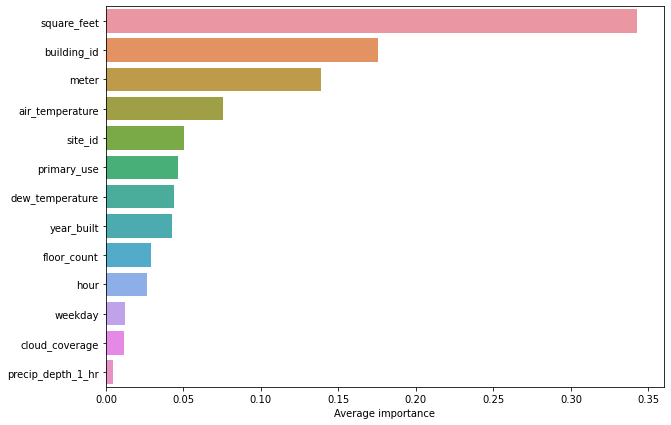

In [8]:
importance = pd.DataFrame([model.feature_importances_ for model in models],
                          columns=X_train.columns,
                          index=[f'Fold {i}' for i in range(1, n_splits + 1)])
importance = importance.T
importance['Average importance'] = importance.mean(axis=1)
importance = importance.sort_values(by='Average importance', ascending=False)

plt.figure(figsize=(10,7))
sns.barplot(x='Average importance', y=importance.index, data=importance);

In [9]:
del X_train
gc.collect()

5311

Now let's repeat **with** embeddings.

In [10]:
X_embeds = pd.read_feather(f'{data_path}/X_embeds.feather')

In [11]:
%%time
models_emb, _, _ = perform_CV(RF_wrapper, X_embeds, y_train, n_splits=n_splits)

Training fold 1...
Fold 1: training RMSLE: 0.864098563002225,   validation RMSLE: 1.1328671057300983

Training fold 2...
Fold 2: training RMSLE: 0.890226607799474,   validation RMSLE: 1.0623810522897528

Training fold 3...
Fold 3: training RMSLE: 0.8116598714628986,   validation RMSLE: 1.146063720532955

Training completed.
> Mean RMSLE across folds: 1.1137706261842686, std: 0.0367351229693389
> OOF RMSLE: 1.1143762735726868
CPU times: user 29min 21s, sys: 1min 8s, total: 30min 29s
Wall time: 8min 25s


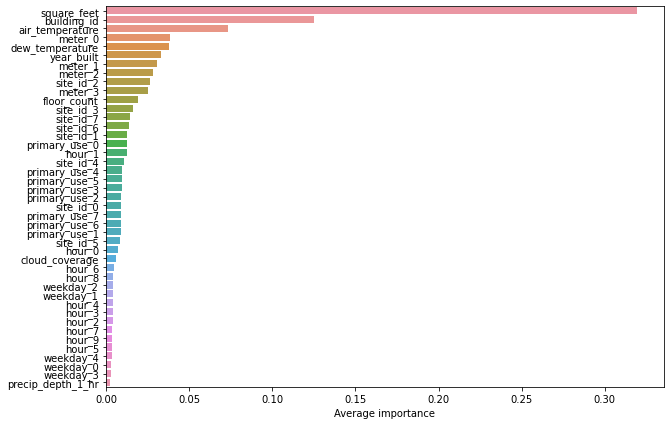

In [12]:
importance = pd.DataFrame([model.feature_importances_ for model in models_emb],
                          columns=X_embeds.columns,
                          index=[f'Fold {i}' for i in range(1, n_splits + 1)])
importance = importance.T
importance['Average importance'] = importance.mean(axis=1)
importance = importance.sort_values(by='Average importance', ascending=False)

plt.figure(figsize=(10,7))
sns.barplot(x='Average importance', y=importance.index, data=importance);

In [13]:
del X_embeds, y_train
gc.collect()

11896

So, using these mysterious embeddings actually worked! Even if, in this case, it only helped performance a little (and was quite a bit slower too!). However, it is well worth knowing that this method exists, as in general it leads to much better performance. For more information, check out the paper [Entity Embeddings of Categorical Variables](https://arxiv.org/pdf/1604.06737.pdf).

That's it. Do upvote this kernel if you found it of any use! 🖖